# Color palette swapping
We can hide an image in another one by switching color palettes.
Let's try to hide `img_secret` in `img`:

In [1]:
using Images
using DitherPunk
using IndirectArrays
using TestImages

img = testimage("peppers")
img_secret = testimage("airplaneF16");

First we dither to eight colors:

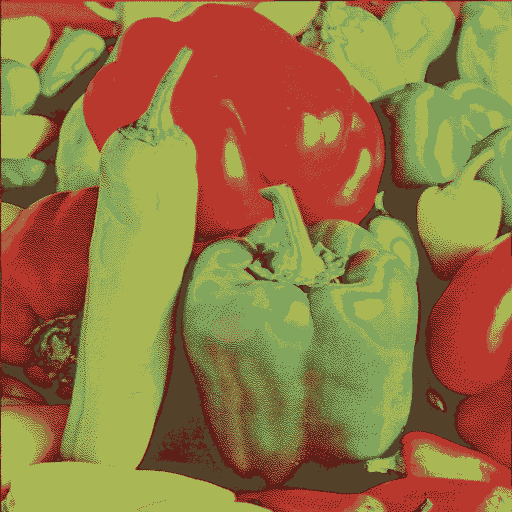

In [2]:
ncolors = 8
d = dither(img, FloydSteinberg(), ncolors)

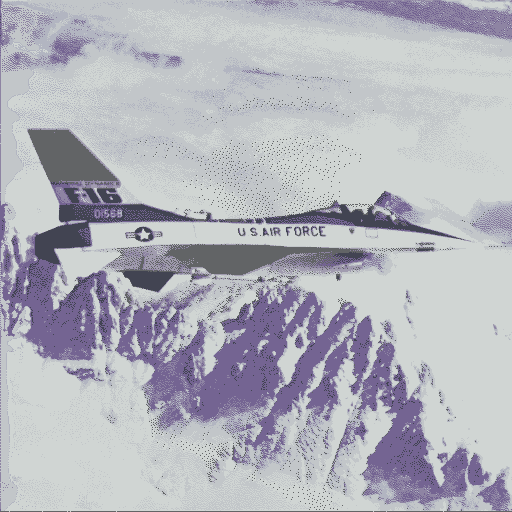

In [3]:
d_secret = dither(img_secret, FloydSteinberg(), ncolors)

Both of these images are IndirectArrays, which means they contain a color scheme

In [4]:
d.values

and a matrix of indices of type `UInt8` pointing to the color in the color scheme:

In [5]:
d.index

512×512 Matrix{Int64}:
 2  2  6  6  6  2  6  2  6  2  6  6  6  …  6  6  6  6  6  6  6  6  6  6  6  6
 2  6  6  6  6  6  6  6  6  6  6  6  6     8  1  8  1  8  1  8  1  8  1  8  1
 2  8  8  6  8  6  8  6  8  6  8  6  6     1  3  3  3  1  3  1  3  1  1  1  1
 2  6  8  8  8  8  8  6  6  8  6  8  8     3  3  1  3  3  3  3  3  1  3  1  1
 6  6  8  8  8  8  8  8  8  8  8  8  8     3  3  3  1  3  3  3  3  3  1  3  1
 2  8  8  8  8  8  8  8  8  8  6  8  8  …  1  3  3  3  3  3  1  3  1  3  3  1
 2  6  8  8  6  8  8  6  8  6  8  8  8     3  3  3  3  3  1  3  3  3  1  1  1
 2  8  8  6  8  8  8  6  8  8  8  8  8     1  3  1  3  3  3  3  3  1  3  3  1
 2  6  8  8  8  8  6  8  6  8  6  6  8     3  3  3  1  3  3  1  3  3  3  3  1
 2  6  8  8  6  8  8  6  8  8  8  8  6     1  1  1  3  3  1  3  1  3  1  3  1
 ⋮              ⋮              ⋮        ⋱  ⋮              ⋮              ⋮  
 2  3  3  5  3  5  3  3  3  7  7  3  7     3  3  3  3  1  3  3  3  3  3  3  3
 2  7  3  7  5  1  7  3  3  3  3  7  3    

Since `typemax(UInt8)` is 255 and therefore larger than `ncolor^2`,
we can fit both images into a single index matrix by modifying the color schemes.
To recover the secret image, it is then only necessary to swap the new color schemes.

In [6]:
combineindex(a, b) = UInt8((a - 1) * ncolors + b)
function uncombineindex(c)
    b = (c - 1) % ncolors + 1
    a = Int((c - b) / ncolors) + 1
    return a, b
end

function combine_images(ia1::IndirectArray, ia2::IndirectArray)
    index = map(t -> combineindex(t...), zip(ia1.index, ia2.index))
    cs1 = similar(ia1.values, ncolors^2)
    cs2 = similar(ia2.values, ncolors^2)

    for i in 1:(ncolors^2)
        a, b = uncombineindex(i)
        cs1[i] = ia1.values[a]
        cs2[i] = ia2.values[b]
    end
    return index, cs1, cs2
end;

Let's test this on our dithered images

In [7]:
index, cs, cs_secret = combine_images(d, d_secret);

When using the color scheme `cs`, we recover the peppers:

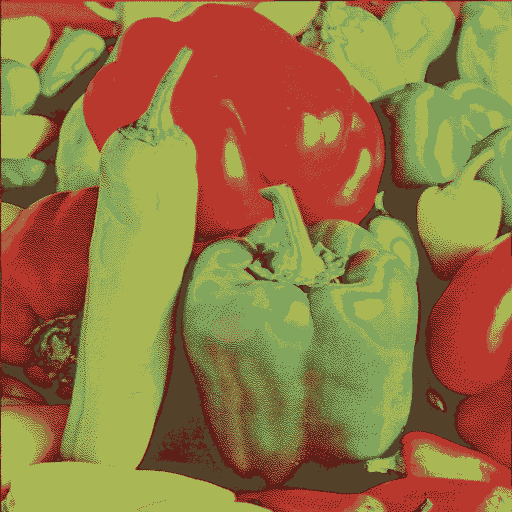

In [8]:
IndirectArray(index, cs)

However, when using the secret color scheme `cs_secret`, the F-16 airplane appears:

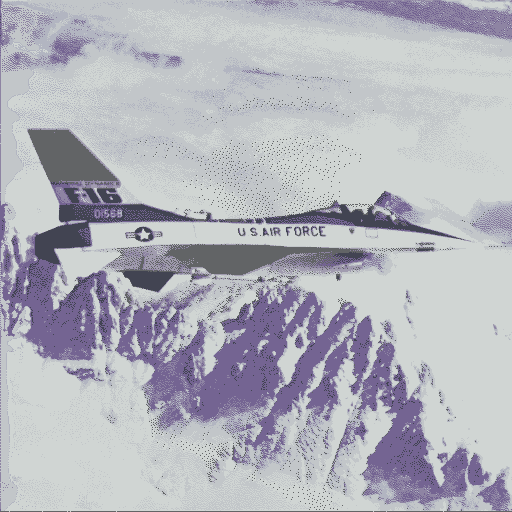

In [9]:
IndirectArray(index, cs_secret)

This certainly isn't a very secure way to hide an image in another one.
However, it can be useful when trying to fit multiple images on low memory microcontrollers.
As a matter of fact, this example was inspired by
[Mark Ferrari's GDC 2016 talk](https://youtu.be/aMcJ1Jvtef0?t=717)
where he used a similar technique for this very purpose.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*